# Creating Winning Tickets

In this notebook we will:
* train a network on CIFAR
* do iterative magnitude pruning on it to receive a sparse network
* test whether the network is a winning ticket by comparing training performance of generated sparse network with training performance of original network (the networks should share the same initialization weight values)  
* extracting relevant structural features from the first convolutional layer

In [1]:
# import necessary libraries

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# download dataset and preprocess dataset

def load_and_prep_cifar(batch_size, shuffle_size):
    # load data set
    (train_ds, test_ds), ds_info = tfds.load(name="cifar10", split=["train","test"], as_supervised=True, with_info=True)
    # tfds.show_examples(train_ds, ds_info)
    
    def prepare_cifar10_data(ds):
        #convert data from uint8 to float32
        ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
        #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
        ds = ds.map(lambda img, target: ((img/128.)-1., target))
        #create one-hot targets
        ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
        #cache this progress in memory, as there is no need to redo it; it is deterministic after all
        ds = ds.cache()
        #shuffle, batch, prefetch
        ds = ds.shuffle(shuffle_size).batch(batch_size).prefetch(2)
        #return preprocessed dataset
        return ds
    
    # prepare data
    train_dataset = train_ds.apply(prepare_cifar10_data)
    test_dataset = test_ds.apply(prepare_cifar10_data)
    
    return train_dataset, test_dataset

In [3]:
# create the model

class CNN2Model(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(CNN2Model, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense2 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense3 = tf.keras.layers.Dense(10, activation="softmax",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]

    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x
            
    
    def get_conv_weights(self):
        return self.conv1.get_weights(), self.conv2.get_weights(), self.dense3.get_weights()
        
    def set_conv_weights(self,weights_conv1, weights_conv2, weights_dense3):
        self.conv1.set_weights(weights_conv1)
        self.conv2.set_weights(weights_conv2)
        self.dense3.set_weights(weights_dense3)
        
    def get_dense_weights(self):
        return self.dense1.get_weights(), self.dense2.get_weights()
        
    def set_dense_weights(self,weights_dense1, weights_dense2):
        self.dense1.set_weights(weights_dense1)
        self.dense2.set_weights(weights_dense2)

In [4]:
# basic train loop

def train_loop(train, test, model, num_epochs):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    for e in tqdm(range(num_epochs)):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()     
    
    return  train_acc, test_acc, train_l, test_l

In [11]:
# train loop of iterative magnitude pruning

def train_loop_imp(train, test, model, pruning_rounds=11, num_epochs_per_pruning=8, pruning_rate_conv=10, pruning_rate_dense=20):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []
    
    # safe initial weights for conv layers (and last layer, because they share the same pruning rate)
    conv_initial_weights = []
    for weight_matrix in model.get_conv_weights():
        conv_initial_weights.append(weight_matrix)
        
    # safe initial weights for dense layers
    dense_initial_weights = []
    for weight_matrix in model.get_dense_weights():
        dense_initial_weights.append(weight_matrix)
        
        
    for r in tqdm(range(pruning_rounds)):
    
        for e in tqdm(range(num_epochs_per_pruning)):

            #train step
            for x, t in train:
                with tf.GradientTape() as tape:
                    pred = model(x)
                    loss = loss_function(t, pred)
                    train_losses.update_state(t, pred)
                    train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
                gradients = tape.gradient(loss, model.trainable_variables)
                # set gradients to zero for all pruned weights
                for gradient_matrix, variables in zip(gradients, model.trainable_variables):
                    gradient_matrix = np.where(variables == 0.0, 0.0, gradient_matrix)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # test step
            for x, t in test:
                pred = model(x)
                test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
                test_losses.update_state(t, pred)

            train_acc.append(train_accuracy.result().numpy())
            test_acc.append(test_accuracy.result().numpy())
            train_l.append(train_losses.result().numpy())
            test_l.append(test_losses.result().numpy())
            train_accuracy.reset_state()
            test_accuracy.reset_state()
            train_losses.reset_state()
            test_losses.reset_state()

        # at end of each round, prune the smallest weights(not including biases) by setting them to zero    
        
        new_conv_weights = []   
        for weight_matrix, init_weights in zip(model.get_conv_weights(), conv_initial_weights):
            # calculate the percentile
            percentile = np.percentile(np.abs(weight_matrix[0][weight_matrix[0] != 0.0].flatten()), pruning_rate_conv,)
            # set pruned weights to zero
            new_conv_weights.append([np.where(weight_matrix[0] < percentile, 0, init_weights[0]), init_weights[1]])
        model.set_conv_weights(new_conv_weights[0], new_conv_weights[1], new_conv_weights[2])
        
        new_dense_weights = []
        for weight_matrix, init_weights in zip(model.get_dense_weights(), dense_initial_weights):
            # calculate the percentile
            percentile = np.percentile(np.abs(weight_matrix[0][weight_matrix[0] != 0.0].flatten()), pruning_rate_dense,)
            # set pruned weights to zero
            new_dense_weights.append([np.where(weight_matrix[0] < percentile, 0, init_weights[0]), init_weights[1]])
        model.set_dense_weights(new_dense_weights[0], new_dense_weights[1])
            
    
    return  train_acc, test_acc, train_l, test_l

In [6]:
# plot the results

def plot_losses(train_acc, test_acc, train_l, test_l, title):
    fig= plt.figure(figsize=(10,6))
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("Loss/Accuracy")
    plt.plot(test_l,label="test loss")
    plt.plot(train_l,label="training loss")
    plt.plot(test_acc,label="test accuracy")
    plt.plot(train_acc,label="training accuracy")
    plt.legend()
    plt.show()

    max_test_acc_control = np.max(test_acc)
    min_test_loss_control = np.min(test_l)
    print(f"lowest testing loss: {min_test_loss_control}")
    print(f"highest testing accuracy: {max_test_acc_control}")

Config:
{'name': 'conv2d_8', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Constant', 'config': {'value': 1e-10}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Weights:
[array([[[[-0.01378252, -0.06626669, -0.06871442, ..., -0.0092731 ,
          -0.09909596,  0.09226364],
         [ 0.08075364,  0.02250995, -0.04006256, ..., -0.03699569,
          -0.03391964,  0.00046381],
         [-0.09000709, -0.00828633,  0.08733906, ...,  0.08932632,
           0.03163923,  0.07907782]],

        [[ 0.05

100%|██████████| 5/5 [07:21<00:00, 88.34s/it]


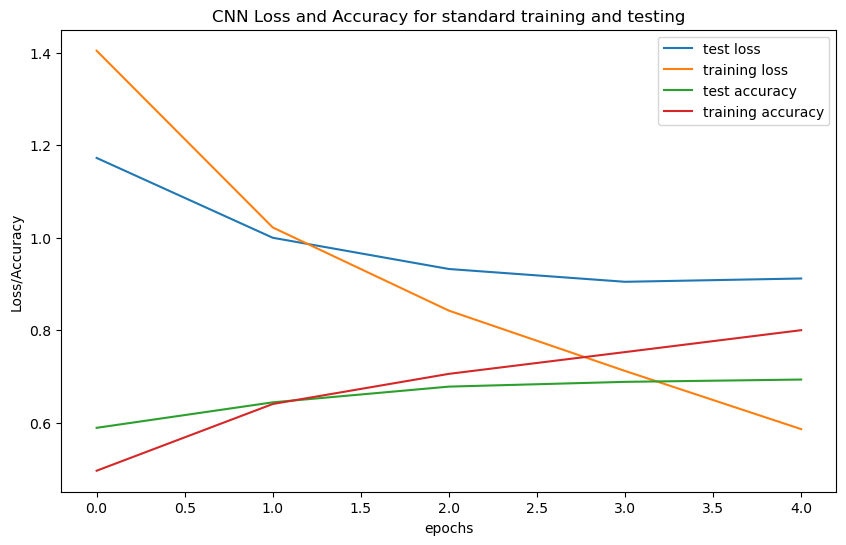

lowest testing loss: 0.9046860337257385
highest testing accuracy: 0.6933000087738037


In [12]:
#train the control model

train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
model = CNN2Model()

#predict something with the model so it initializes the weights
model(list(train_dataset)[0][0])

#save the initial weights to reuse for IMP
conv_initial_weights = []
for weight_matrix in model.get_conv_weights():
    conv_initial_weights.append(weight_matrix)
        
dense_initial_weights = []
for weight_matrix in model.get_dense_weights():
    dense_initial_weights.append(weight_matrix)

for layer in model.layers: 
    print("Config:\n{}\nWeights:\n{}\n".format(layer.get_config(), layer.get_weights()))

train_acc, test_acc, train_l, test_l = train_loop(train_dataset, test_dataset, model, num_epochs=5)
plot_losses(train_acc, test_acc, train_l, test_l,"CNN Loss and Accuracy for standard training and testing")

In [14]:
# check if the weights are correctly initialized

train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
model = CNN2Model()

#set the initial weights before IMP
model(list(train_dataset)[0][0])
model.set_conv_weights(conv_initial_weights[0], conv_initial_weights[1], conv_initial_weights[2])
model.set_dense_weights(dense_initial_weights[0], dense_initial_weights[1])

for layer in model.layers: 
    print("Config:\n{}\nWeights:\n{}\n".format(layer.get_config(), layer.get_weights()))

Config:
{'name': 'conv2d_12', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Constant', 'config': {'value': 1e-10}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Weights:
[array([[[[-0.01378252, -0.06626669, -0.06871442, ..., -0.0092731 ,
          -0.09909596,  0.09226364],
         [ 0.08075364,  0.02250995, -0.04006256, ..., -0.03699569,
          -0.03391964,  0.00046381],
         [-0.09000709, -0.00828633,  0.08733906, ...,  0.08932632,
           0.03163923,  0.07907782]],

        [[ 0.0

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [23:12<00:00, 464.31s/it]


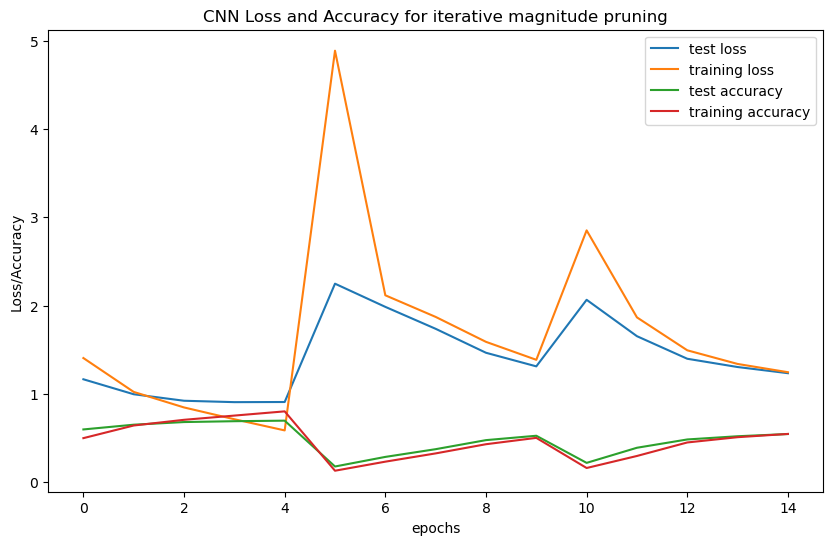

lowest testing loss: 0.9046980738639832
highest testing accuracy: 0.6948000192642212


In [15]:
# train the model with iterative magnitude pruning

train_acc, test_acc, train_l, test_l = train_loop_imp(train_dataset, test_dataset, model, 3, 5)
plot_losses(train_acc, test_acc, train_l, test_l,"CNN Loss and Accuracy for iterative magnitude pruning")

In [ ]:
# retrain the model with pruned weights to check whether winning ticket by comparing to complete model

In [ ]:
# extract features from the sparse model if Winning Ticket